# Loading the HST data, normalising and shifting

### Introduction

This workbook takes the HST fits files and creates numpy arrays of shifted and normalised data. It then looks at how accurately the alignment was done. The bottom part of this notebook is specific to the SiIV lines and will need changing.

## The code

The code written below uses functions in ```src/calculations.py```. It is capable of looking for variations in the entire dataset (e.g. it is capable of running over each HST visit).

### Import the standard routines and load parameters

In [1]:
import numpy as np
import json, sys, os

import matplotlib.pyplot as plt
from matplotlib import rc, cm

# get the path of the current directory
path = os.getcwd()
home = os.path.dirname(path)

# Print the repository home directory
print("Repository home directory:",home)

# Add the src folder to the system path
sys.path.append(home+'/src')

# Import the python functions from src
from calculations import Calc, Model, Stats

# We shorten the functions name to make it easier to call the required a functions
c   = Calc()
m   = Model()
s   = Stats()

Repository home directory: /home/pas/science/exocomets


In [2]:
# Importing parameters from a json file.
with open(home+'/params.json') as param_file:    
   param = json.load(param_file)

In [3]:
# We read in the data directories we are using. To see what directories this is open params.json.
datadirs = param["datadirs"]

# We select part A which is the red end of the spectrum (the other part being B, which is the blue end)
part     = param["BetaPictoris"]["part"]

### Get the data

In [4]:
D = []

print("Data used for this analysis:")

for i in sorted(datadirs):
    if param["filenames"]["split_files"] == 'yes':
        if datadirs[i][5:-1] in ["2017-04-23","2017-06-10","2017-08-04","2017-10-21","2017-11-26","2018-03-17","2018-05-09"]:
            print("\n",datadirs[i])
            D.append(c.GetData(param, home+'/'+datadirs[i]))
    else:
        print("\n",datadirs[i][5:-1])
        D.append(c.GetData(param, home+'/'+datadirs[i]))
    
# We save the data
if param["filenames"]["split_files"] == "yes":
    np.savez(home+'/data/D_'+part+'_split.npz', D, dtype=object)
else:
    np.savez(home+'/data/D_'+part+'.npz', D, dtype=object)

Data used for this analysis:

 data/2017-04-23/
	AVM shift: 0.0" 	EXP: 526s, 	Date: 2017-04-22, Time: 23:36:06 UTC
	AVM shift: 0.0" 	EXP: 526s, 	Date: 2017-04-22, Time: 23:48:03 UTC
	AVM shift: 0.0" 	EXP: 526s, 	Date: 2017-04-23, Time: 00:00:00 UTC
	AVM shift: 0.0" 	EXP: 526s, 	Date: 2017-04-23, Time: 00:11:57 UTC
	AVM shift: -1.25" 	EXP: 664s, 	Date: 2017-04-23, Time: 00:31:55 UTC
	AVM shift: -1.25" 	EXP: 664s, 	Date: 2017-04-23, Time: 00:45:32 UTC
	AVM shift: -1.25" 	EXP: 664s, 	Date: 2017-04-23, Time: 00:59:09 UTC
	AVM shift: -1.25" 	EXP: 664s, 	Date: 2017-04-23, Time: 01:12:46 UTC
	AVM shift: 1.1" 	EXP: 664s, 	Date: 2017-04-23, Time: 02:07:24 UTC
	AVM shift: 1.1" 	EXP: 664s, 	Date: 2017-04-23, Time: 02:21:01 UTC
	AVM shift: 1.1" 	EXP: 664s, 	Date: 2017-04-23, Time: 02:34:38 UTC
	AVM shift: 1.1" 	EXP: 664s, 	Date: 2017-04-23, Time: 02:48:15 UTC

 data/2017-06-10/
	AVM shift: 0.0" 	EXP: 526s, 	Date: 2017-06-10, Time: 20:02:24 UTC
	AVM shift: 0.0" 	EXP: 526s, 	Date: 2017-06-10, Time: 

/usr/lib/python3.10/site-packages/numpy/lib/npyio.py:713: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  val = np.asanyarray(val)


### We now normalise, shift and re-normalise the data 

In [5]:
# Load the data into the multidimentional array D
if param["filenames"]["split_files"] == "yes":
    D = c.LoadData(home+'/data/D_'+part+'_split.npz')
else:
    D = c.LoadData(home+'/data/D_'+part+'.npz')
    
# Normalise the data
Dn = c.NormSpec(param, D)

# Shift the data relative to the first spectrum of each visit
Dns = c.ShiftSpec(param, Dn)

# Re normalise the data
Dnsn = c.NormSpec(param, Dns)

# We save the normalised and shifted data
if param["filenames"]["split_files"] == "yes":
    np.savez(home+'/data/Dnsn_'+part+'_split.npz', Dnsn, dtype=object)
else:
    np.savez(home+'/data/Dnsn_'+part+'.npz', Dnsn, dtype=object)

/home/pas/science/exocomets/src/calculations.py:292: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(Dn)




Normalising the spectra relative to first spectrum...
Done



Shifting the 1st observation:


Observations done at: 2017-04-22 23:36:06
______________________________________________

 Pixel shift [pix]:	 0
 W shift [A]:		 0.0
 RV shift [km/s]:	 0
______________________________________________


Observations done at: 2017-04-22 23:48:03
______________________________________________

 Pixel shift [pix]:	 -1
 W shift [A]:		 -0.01
 RV shift [km/s]:	 -2
______________________________________________


Observations done at: 2017-04-23 00:00:00
______________________________________________

 Pixel shift [pix]:	 3
 W shift [A]:		 0.03
 RV shift [km/s]:	 6
______________________________________________


Observations done at: 2017-04-23 00:11:57
______________________________________________

 Pixel shift [pix]:	 -5
 W shift [A]:		 -0.05
 RV shift [km/s]:	 -11
______________________________________________


Observations done at: 2017-04-23 00:31:55
________________________________________

/home/pas/science/exocomets/src/calculations.py:247: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(Ds)


Done


In [6]:
# Setting the parameters for the plots
plotting_params = {'backend': 'wxAgg',
                   'font.family': 'serif',
                   'font.size': 22,
                   'lines.markersize' : 2,
                   'axes.labelsize': 22,
                   'legend.fontsize': 22,
                   'xtick.labelsize': 22,
                   'ytick.labelsize': 22,
                   'text.usetex': True}

plt.rcParams.update(plotting_params)

### Let us have a quick look at how well the alignment worked

We do this by fitting a Gaussian to the non-variable CO line and measure the lateral movement.

Text(0, 0.5, 'Flux [erg/s/cm$^2$/\\AA]')

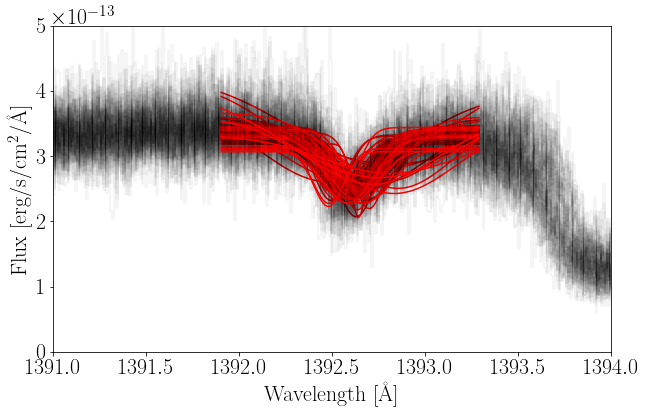

In [7]:
import numpy as np
from scipy.optimize import curve_fit

def gauss(x,a,x0,sigma,bl):
    return -a*np.exp(-(x-x0)**2/(2*(sigma)**2))+bl

w = Dnsn[0][0][0]
spec        = []
minimums = []

s1, s2 = c.RegionSelect(w, 1391.9, 1393.3)
w_c = w[s1:s2]

for i in range(len(Dnsn)):          # Cycle over number of visits
    for j in range(len(Dnsn[i])):   # Cycle over number of fits files each visit
        spec.append(Dnsn[i][j][1])
        minimums.append((w[s1:s2][np.argmin(Dnsn[i][j][1][s1:s2])]))

spec = np.array(spec)

lateral = []

fig = plt.figure(figsize=(10.0,6.0))
for i in range(len(spec)):
    popt,pcov = curve_fit(gauss,w_c,spec[i][s1:s2],p0=[3.5e-13,1392.6,0.1,3.3e-13], bounds=([-np.inf, -np.inf, -np.inf], [np.inf, np.inf, np.inf]), maxfev = 2800)
    #print(popt)                    
    lateral.append(popt[1])
    plt.step(w,spec[i],color='k',alpha=0.05)
    plt.plot(w_c,gauss(w_c,*popt),color="red")

plt.xlim(1391,1394)
plt.ylim(0,0.5e-12)
plt.xlabel(r'Wavelength [\AA]')
plt.ylabel(r'Flux [erg/s/cm$^2$/\AA]')

The standard deviation of the lateral shifts (in Ångstrøm): 0.07614898851768728


Text(0, 0.5, 'Wavelength shift')

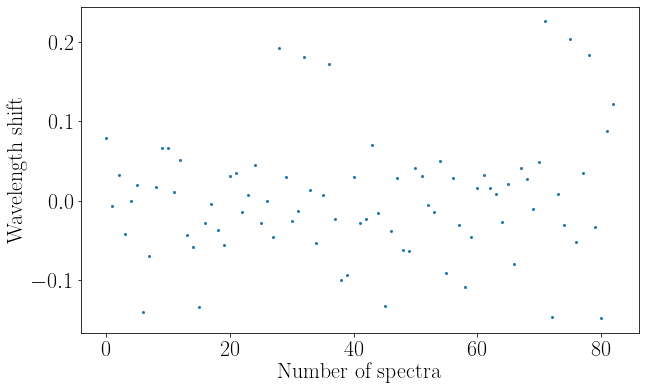

In [8]:
lateral = np.array(lateral)
lateral = lateral - np.median(lateral)

print("The standard deviation of the lateral shifts (in Ångstrøm):",np.std(lateral))

fig = plt.figure(figsize=(10.0,6.0))
plt.scatter(np.arange(len(lateral)),lateral)
plt.xlabel(r'Number of spectra')
plt.ylabel(r'Wavelength shift')

Text(0.5, 0, 'Wavelength [\\AA]')

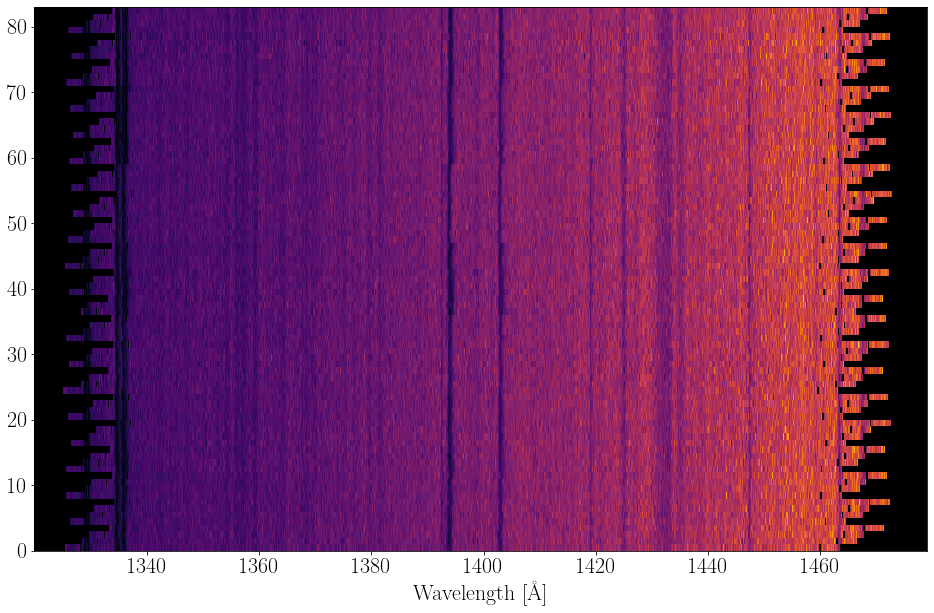

In [9]:
import numpy as np
from scipy.optimize import curve_fit

def gauss(x,a,x0,sigma,bl):
    return -a*np.exp(-(x-x0)**2/(2*(sigma)**2))+bl

w = Dnsn[0][0][0]
s1, s2 = c.RegionSelect(w, 1320, 1479)
w_c = w[s1:s2]

spec_c = []
for i in range(len(spec)):
    spec_c.append(spec[i][s1:s2])

spec_c = np.array(spec_c)

spec_range   = len(w_c)
rows         = len(spec_c)

S            = spec_c.reshape(rows,spec_range)
cmap = plt.get_cmap('inferno')

fig = plt.figure(figsize=(16.0,10.0))
plt.imshow(S,cmap=cmap,extent=[w_c[0],w_c[-1],0,len(spec_c)],interpolation='none',aspect='auto')
plt.xlabel(r'Wavelength [\AA]')